In [ ]:
# Install required packages
!uv pip install tensorflow
#cuda: !uv pip install tensorflow[and-cuda]
!uv pip install keras matplotlib seaborn numpy pandas transformers

In [11]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../02")))
from utils import display_nn_graph

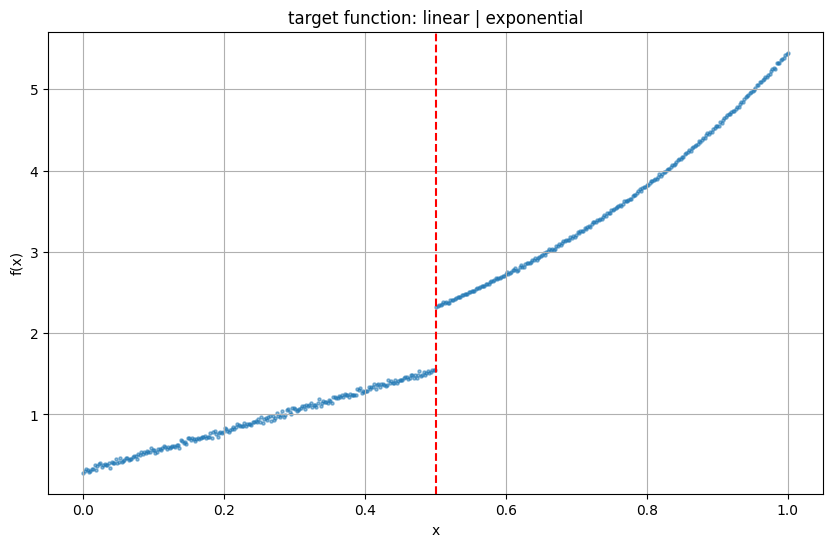

In [124]:
import numpy as np
import matplotlib.pyplot as plt


# function: different behavior for x < 0.5 and x >= 0.5    
function = lambda x: np.where(x < 0.5,
                2.5 * x + 0.3 + np.random.normal(0, 0.02, x.shape),  # Linear growth for x < 0.5
                np.exp(2 * (x - 0.2)) + 0.5 + np.random.normal(0, 0.01, x.shape))  # exponential behavior for x >= 0.5

#plot the function
x_vals = np.linspace(0, 1, 500).reshape(-1, 1)
y_vals = function(x_vals)
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, s=5, alpha=0.5) 
plt.title("target function: linear | exponential")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.axvline(x=0.5, color='red', linestyle='--')
plt.show()


Model: "moe-stratch-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gating_network (Sequential)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ gating_dense (Dense)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ gating_output (Dense)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expert_0 (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expert_0_1_dense (Dense)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expert_0_2_dense (Dense)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expert_0_output (Dense)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expert_1 (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expert_1_1_dense (Dense)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expert_1_2_dense (Dense)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expert_1_output (Dense)    │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


CUSTOM HIERARCHICAL STRUCTURE VIEW
MixtureOfExperts Model: moe-stratch-model
├─ Gating Network:
│  ├─ gating_dense: Dense
│     └─ units: 16
│  └─ gating_output: Dense
│     └─ units: 2
├─ Experts (2 total):
│  ├─ Expert 0: expert_0
│  │     ├─ expert_0_1_dense: Dense
│  │        └─ units: 32
│  │     ├─ expert_0_2_dense: Dense
│  │        └─ units: 16
│  │     └─ expert_0_output: Dense
│  │        └─ units: 1
│  └─ Expert 1: expert_1
│        ├─ expert_1_1_dense: Dense
│           └─ units: 32
│        ├─ expert_1_2_dense: Dense
│           └─ units: 16
│        └─ expert_1_output: Dense
│           └─ units: 1
└─ Final output: Weighted combination of expert outputs

Parameter Summary:
├─ Gating Network: 0 params
├─ Expert 0: 0 params
└─ Expert 1: 0 params

Total: 0 params
Creating visualization for model: moe-stratch-model
Processing input layer...
Processing layer 0: Sequential
Processing layer 1: Sequential
Processing layer 2: Sequential
Visualization saved as 'moe-model-scratch.p

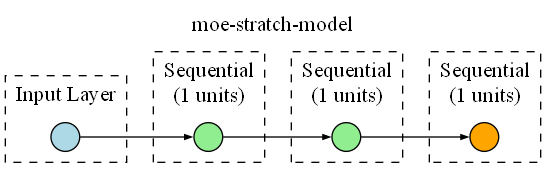

Creating visualization for model: gating_network
Processing input layer...
Processing layer 0: Dense
Processing layer 1: Dense
Visualization saved as 'moe-scratch-gating-network.png'
Visualization saved as 'moe-scratch-gating-network.png'


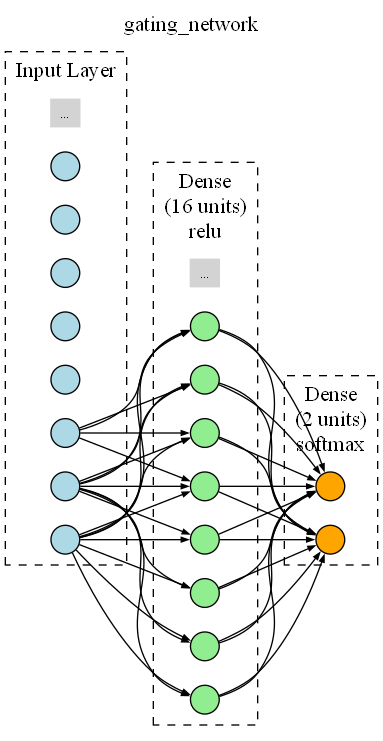

Creating visualization for model: expert_0
Processing input layer...
Processing layer 0: Dense
Processing layer 1: Dense
Processing layer 2: Dense
Visualization saved as 'moe-scratch-expert-0.png'
Visualization saved as 'moe-scratch-expert-0.png'


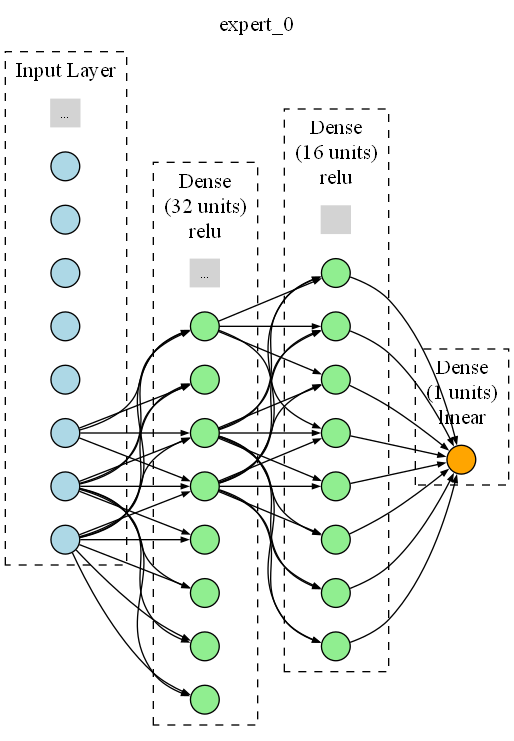

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

#hyperparameters
epochs = 200

class MixtureOfExperts(keras.Model):
    def __init__(self, num_experts=2, expert_units=32, gating_units=16, **kwargs):
        super(MixtureOfExperts, self).__init__(**kwargs)
        self.num_experts = num_experts
        self.name = 'moe-stratch-model'
        
        # Gating network: outputs weights for each expert (softmax)
        # learns to assign probabilities to each expert based on input
        self.gating_network = keras.Sequential([
            layers.Dense(gating_units, activation='relu', name='gating_dense'), # reLU activation for gating hidden layer
            layers.Dense(num_experts, activation='softmax', name='gating_output') # ensure weights sum to 1
        ], name='gating_network')
        
        # Expert networks: each expert is an independent neural network
        # each can specialize in different patterns or regions of the input space
        # i.e. linear, sinusoidal relationships
        self.experts = []
        for i in range(num_experts):
            if i == 0:
                # Expert 0: Specialized for LINEAR patterns (x < 0.5)
                # ReLU activation: piecewise linear, unbounded, great for monotonic functions
                expert = keras.Sequential([
                    layers.Dense(expert_units, activation='relu', name=f'expert_{i}_1_dense'),      # ReLU for linear growth
                    layers.Dense(expert_units // 2, activation='relu', name=f'expert_{i}_2_dense'), # More ReLU for refinement
                    layers.Dense(1, name=f'expert_{i}_output')
                ], name=f'expert_{i}')
            else:
                # Expert 1: Specialized for OSCILLATORY patterns (x >= 0.5)
                # Tanh activation: smooth, bounded [-1,1], perfect for sinusoidal shapes
                expert = keras.Sequential([
                    layers.Dense(expert_units, activation='tanh', name=f'expert_{i}_1_dense'),      # Tanh for oscillations
                    layers.Dense(expert_units // 2, activation='tanh', name=f'expert_{i}_2_dense'), # More tanh for smooth curves
                    layers.Dense(1, name=f'expert_{i}_output')
                ], name=f'expert_{i}')
            
            self.experts.append(expert)
    
    
    def call(self, inputs):
        # Get gating weights (probabilities for each expert)
        gating_weights = self.gating_network(inputs)  # Shape: (batch_size, num_experts)
        
        # Get predictions from each expert
        expert_outputs = []
        for expert in self.experts:
            expert_pred = expert(inputs)  # Shape: (batch_size, 1)
            expert_outputs.append(expert_pred)
        
        # Stack expert outputs: Shape (batch_size, num_experts, 1)
        expert_outputs = tf.stack(expert_outputs, axis=1)
        
        # Expand gating weights to match expert outputs shape: (batch_size, num_experts, 1)
        gating_weights = tf.expand_dims(gating_weights, axis=-1)
        
        # Weighted sum: final output = sum(gating_weight_i * expert_output_i)
        # Smooth transition between experts based on gating weights
        final_output = tf.reduce_sum(gating_weights * expert_outputs, axis=1)
        
        return final_output, gating_weights, expert_outputs
    
    def get_config(self):
        return {
            'num_experts': self.num_experts,
            'expert_units': self.expert_units if hasattr(self, 'expert_units') else 32,
            'gating_units': self.gating_units if hasattr(self, 'gating_units') else 16
        }

# Custom training step to handle the multiple outputs
class MoETrainer(keras.Model):
    def __init__(self, moe_model, **kwargs):
        super(MoETrainer, self).__init__(**kwargs)
        self.moe_model = moe_model
        # Track expert contributions during training
        self.gating_history = []  # Store average gating weights per epoch
        # Use TensorFlow Variables to accumulate statistics (works in graph mode)
        self._epoch_gating_sum = None
        self._epoch_contrib_sum = None
        self._batch_count = None
    
    def call(self, inputs):
        return self.moe_model(inputs)[0]  # Return only the final output for standard usage
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            final_output, gating_weights, expert_outputs = self.moe_model(x, training=True)
            loss = self.compiled_loss(y, final_output)
        
        gradients = tape.gradient(loss, self.moe_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.moe_model.trainable_variables))
        
        self.compiled_metrics.update_state(y, final_output)
        
        # Track gating weights and expert contributions for this batch
        # Calculate means using TensorFlow ops (stay in graph mode)
        batch_gating_mean = tf.reduce_mean(gating_weights, axis=0)  # Shape: (num_experts, 1)
        
        # Calculate weighted expert contributions to final output
        weighted_contributions = gating_weights * expert_outputs
        batch_contribution_mean = tf.reduce_mean(weighted_contributions, axis=0)  # Shape: (num_experts, 1)
        
        # Initialize accumulators if needed
        if self._epoch_gating_sum is None:
            num_experts = tf.shape(batch_gating_mean)[0]
            self._epoch_gating_sum = tf.Variable(tf.zeros_like(batch_gating_mean), trainable=False)
            self._epoch_contrib_sum = tf.Variable(tf.zeros_like(batch_contribution_mean), trainable=False)
            self._batch_count = tf.Variable(0.0, trainable=False)
        
        # Accumulate statistics
        self._epoch_gating_sum.assign_add(batch_gating_mean)
        self._epoch_contrib_sum.assign_add(batch_contribution_mean)
        self._batch_count.assign_add(1.0)
        
        return {m.name: m.result() for m in self.metrics}

# Callback to capture gating statistics at epoch end
class GatingHistoryCallback(keras.callbacks.Callback):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer
    
    def on_epoch_end(self, epoch, logs=None):
        """Aggregate batch-level statistics at the end of each epoch."""
        if self.trainer._batch_count is not None and self.trainer._batch_count.numpy() > 0:
            # Calculate averages from accumulated sums
            num_batches = self.trainer._batch_count.numpy()
            epoch_gating_mean = (self.trainer._epoch_gating_sum.numpy() / num_batches)
            epoch_contribution_mean = (self.trainer._epoch_contrib_sum.numpy() / num_batches)
            
            # Store epoch-level statistics
            self.trainer.gating_history.append({
                'epoch': epoch,
                'gating_weights': epoch_gating_mean.flatten(),  # Shape: (num_experts,)
                'expert_contributions': epoch_contribution_mean.flatten()  # Shape: (num_experts,)
            })
            
            # Reset accumulators for next epoch
            self.trainer._epoch_gating_sum.assign(tf.zeros_like(self.trainer._epoch_gating_sum))
            self.trainer._epoch_contrib_sum.assign(tf.zeros_like(self.trainer._epoch_contrib_sum))
            self.trainer._batch_count.assign(0.0)
            
            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"\nEpoch {epoch + 1} - Expert Analysis:")
                for i, (gate_w, contrib) in enumerate(zip(epoch_gating_mean.flatten(), 
                                                           epoch_contribution_mean.flatten())):
                    print(f"  Expert {i+1}: Gating={gate_w:.4f}, Contribution={contrib:.4f}")

# Generate dataset
def generate_data(n_samples=1000):
    np.random.seed(42)
    x = np.random.uniform(0, 1, n_samples).reshape(-1, 1)
    
    # function: different behavior for x < 0.5 and x >= 0.5    
    y = np.where(x < 0.5, 
                 2.5 * x + 0.3 + np.random.normal(0, 0.02, x.shape),  # Linear: y = 2.5x + 0.3
                 np.exp(2 * (x - 0.2)) + 0.5 + np.random.normal(0, 0.01, x.shape))  # Exponential: y = exp(2(x - 0.2)) + 0.5
    
    return x, y    
    
    return x, y

# Load gating history
def load_gating_history(filename):
    """Load gating history from file."""
    data = np.load(filename)
    return {
        'epochs': data['epochs'],
        'gating_weights': data['gating_weights'],
        'contributions': data['contributions']
    }

# Visualize gating evolution
def plot_gating_evolution(gating_history):
    """Visualize how gating weights and contributions evolve during training."""
    if not gating_history:
        print("No gating history to plot.")
        return
    
    epochs = [h['epoch'] for h in gating_history]
    gating_weights = np.array([h['gating_weights'] for h in gating_history])
    contributions = np.array([h['expert_contributions'] for h in gating_history])
    
    num_experts = gating_weights.shape[1]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Gating weights evolution
    ax1 = axes[0]
    for i in range(num_experts):
        ax1.plot(epochs, gating_weights[:, i], 
                linewidth=2, marker='o', markersize=3,
                label=f'Expert {i+1} Gating Weight', alpha=0.8)
    
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Average Gating Weight', fontsize=12)
    ax1.set_title('Evolution of Gating Weights During Training\n(How the gating network assigns importance to each expert)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot 2: Expert contributions evolution
    ax2 = axes[1]
    for i in range(num_experts):
        ax2.plot(epochs, contributions[:, i], 
                linewidth=2, marker='s', markersize=3,
                label=f'Expert {i+1} Contribution', alpha=0.8)
    
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Average Weighted Contribution', fontsize=12)
    ax2.set_title('Evolution of Expert Contributions to Final Output\n(Gating weight × Expert output)', 
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("GATING EVOLUTION SUMMARY")
    print("="*60)
    print(f"\nInitial epoch (Epoch {epochs[0]}):")
    for i in range(num_experts):
        print(f"  Expert {i+1}: Gating={gating_weights[0, i]:.4f}, Contribution={contributions[0, i]:.4f}")
    
    print(f"\nFinal epoch (Epoch {epochs[-1]}):")
    for i in range(num_experts):
        print(f"  Expert {i+1}: Gating={gating_weights[-1, i]:.4f}, Contribution={contributions[-1, i]:.4f}")
    
    print(f"\nChange over training:")
    for i in range(num_experts):
        gate_change = gating_weights[-1, i] - gating_weights[0, i]
        contrib_change = contributions[-1, i] - contributions[0, i]
        print(f"  Expert {i+1}: Δ Gating={gate_change:+.4f}, Δ Contribution={contrib_change:+.4f}")

# Create and train the model
def create_moe(num_experts=2, expert_units=32, gating_units=16):    
    # Create MoE model
    moe = MixtureOfExperts(num_experts=num_experts, expert_units=expert_units, gating_units=gating_units)    
    return moe

def train_moe(moe):
    # Generate data
    x_train, y_train = generate_data(2_000)
    x_test, y_test = generate_data(500)
    
    # Wrap for training
    trainer = MoETrainer(moe)
    trainer.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Create callback to track gating history
    gating_callback = GatingHistoryCallback(trainer)
    
    # Train the model
    # both experts and gating network are trained simultaneously via backpropagation
    print("Training Mixture of Experts...")
    history = trainer.fit(x_train, y_train, 
                         batch_size=32, 
                         epochs=epochs, 
                         validation_data=(x_test, y_test),
                         callbacks=[gating_callback],
                         verbose=1)
    trainer.save("moe-model-scratch.keras")
    
    return x_test, y_test, trainer

def test_expert_usage(moe_model, x_test, y_test):
    print("\n" + "="*60)
    print("MIXTURE OF EXPERTS")
    print("="*60)
    
    # Select a few test samples to demonstrate
    sample_indices = [0, 100, 200, 300, 400, 499]
    
    for idx in sample_indices:
        x_sample = x_test[idx:idx+1]  # Keep batch dimension
        y_true = y_test[idx]
        
        # Get all outputs from MoE
        final_pred, gating_weights, expert_outputs = moe_model(x_sample)
        
        # Extract values
        final_pred_val = final_pred.numpy()[0, 0]
        gating_weights_val = gating_weights.numpy()[0, :, 0]  # Shape: (2,)
        expert_outputs_val = expert_outputs.numpy()[0, :, 0]  # Shape: (2,)
        
        print(f"\nSample {idx}: x = {float(x_sample[0, 0]):.3f}")
        print(f"True y = {float(y_true):.3f}")
        print(f"Final prediction = {float(final_pred_val):.3f}")
        print(f"Gating weights: Expert 1 = {float(gating_weights_val[0]):.3f}, Expert 2 = {float(gating_weights_val[1]):.3f}")
        print(f"Expert 1 output = {float(expert_outputs_val[0]):.3f}")
        print(f"Expert 2 output = {float(expert_outputs_val[1]):.3f}")
        
        # Determine which expert is dominant
        dominant_expert = np.argmax(gating_weights_val) + 1
        print(f"→ Dominant expert: Expert {dominant_expert}")
        
        # Show the weighted combination
        weighted_expert1 = gating_weights_val[0] * expert_outputs_val[0]
        weighted_expert2 = gating_weights_val[1] * expert_outputs_val[1]
        print(f"Weighted contributions: Expert 1 = {weighted_expert1:.3f}, Expert 2 = {weighted_expert2:.3f}")
        print(f"Sum of weighted contributions = {weighted_expert1 + weighted_expert2:.3f}")

# Visualization function
def plot_results(moe_model, x_test, y_test):
    # Sort test data for smooth plotting
    sorted_indices = np.argsort(x_test[:, 0])
    x_sorted = x_test[sorted_indices]
    y_sorted = y_test[sorted_indices]
    
    # Get predictions
    final_pred, gating_weights, expert_outputs = moe_model(x_sorted)
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Overall prediction vs true
    plt.subplot(2, 2, 1)
    plt.scatter(x_test, y_test, alpha=0.5, s=10, label='True data')
    plt.plot(x_sorted[:, 0], final_pred.numpy()[:, 0], 'r-', linewidth=2, label='MoE Prediction')
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.5, label='Domain boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mixture of Experts: Overall Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Expert outputs
    plt.subplot(2, 2, 2)
    plt.scatter(x_test, y_test, alpha=0.5, s=10, label='True data')
    plt.plot(x_sorted[:, 0], expert_outputs.numpy()[:, 0, 0], 'g--', linewidth=2, label='Expert 1')
    plt.plot(x_sorted[:, 0], expert_outputs.numpy()[:, 1, 0], 'b--', linewidth=2, label='Expert 2')
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Individual Expert Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Gating network weights
    plt.subplot(2, 2, 3)
    plt.plot(x_sorted[:, 0], gating_weights.numpy()[:, 0, 0], 'g-', linewidth=2, label='Expert 1 weight')
    plt.plot(x_sorted[:, 0], gating_weights.numpy()[:, 1, 0], 'b-', linewidth=2, label='Expert 2 weight')
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('Gating weight')
    plt.title('Gating Network Weights')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Expert specialization
    plt.subplot(2, 2, 4)
    expert1_active = gating_weights.numpy()[:, 0, 0] > 0.5
    expert2_active = gating_weights.numpy()[:, 1, 0] > 0.5
    
    plt.scatter(x_sorted[expert1_active, 0], y_sorted[expert1_active], 
                c='green', alpha=0.6, s=20, label='Expert 1 dominant')
    plt.scatter(x_sorted[expert2_active, 0], y_sorted[expert2_active], 
                c='blue', alpha=0.6, s=20, label='Expert 2 dominant')
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Expert Specialization by Input Region')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# create model
moe_model = create_moe()

moe_model.summary(expand_nested=True)

display_nn_graph(moe_model,"moe-model-scratch")
# display gating model
display_nn_graph(moe_model.gating_network,"moe-scratch-gating-network")
# display expert_0 model
display_nn_graph(moe_model.experts[0],"moe-scratch-expert-0")

Training Mixture of Experts...
Epoch 1/200


c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:648: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:648: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - mae: 1.4090 - loss: 0.9630 - val_loss: 1.0371 - val_mae: 0.8460
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - mae: 1.4090 - loss: 0.9630 - val_loss: 1.0371 - val_mae: 0.8460
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mae: 0.7037 - loss: 2.3348 - val_loss: 0.4979 - val_mae: 0.5878
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mae: 0.7037 - loss: 2.3348 - val_loss: 0.4979 - val_mae: 0.5878
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - mae: 0.4834 - loss: 2.3288 - val_loss: 0.2464 - val_mae: 0.3709
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - mae: 0.4834 - loss: 2.3288 - val_loss: 0.2464 - val_mae: 0.3709
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - mae: 0.3247 - loss: 2.3045 - val_loss: 0.1537 - val_mae: 0.2955
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - mae: 0.3247 - loss: 2.3045 - val_loss: 0.1537 - val_mae: 0.2955
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - mae: 0.2907 - loss: 2.2

C:\Users\m.dipaolo\AppData\Local\Temp\ipykernel_15316\832374042.py:300: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"True y = {float(y_true):.3f}")


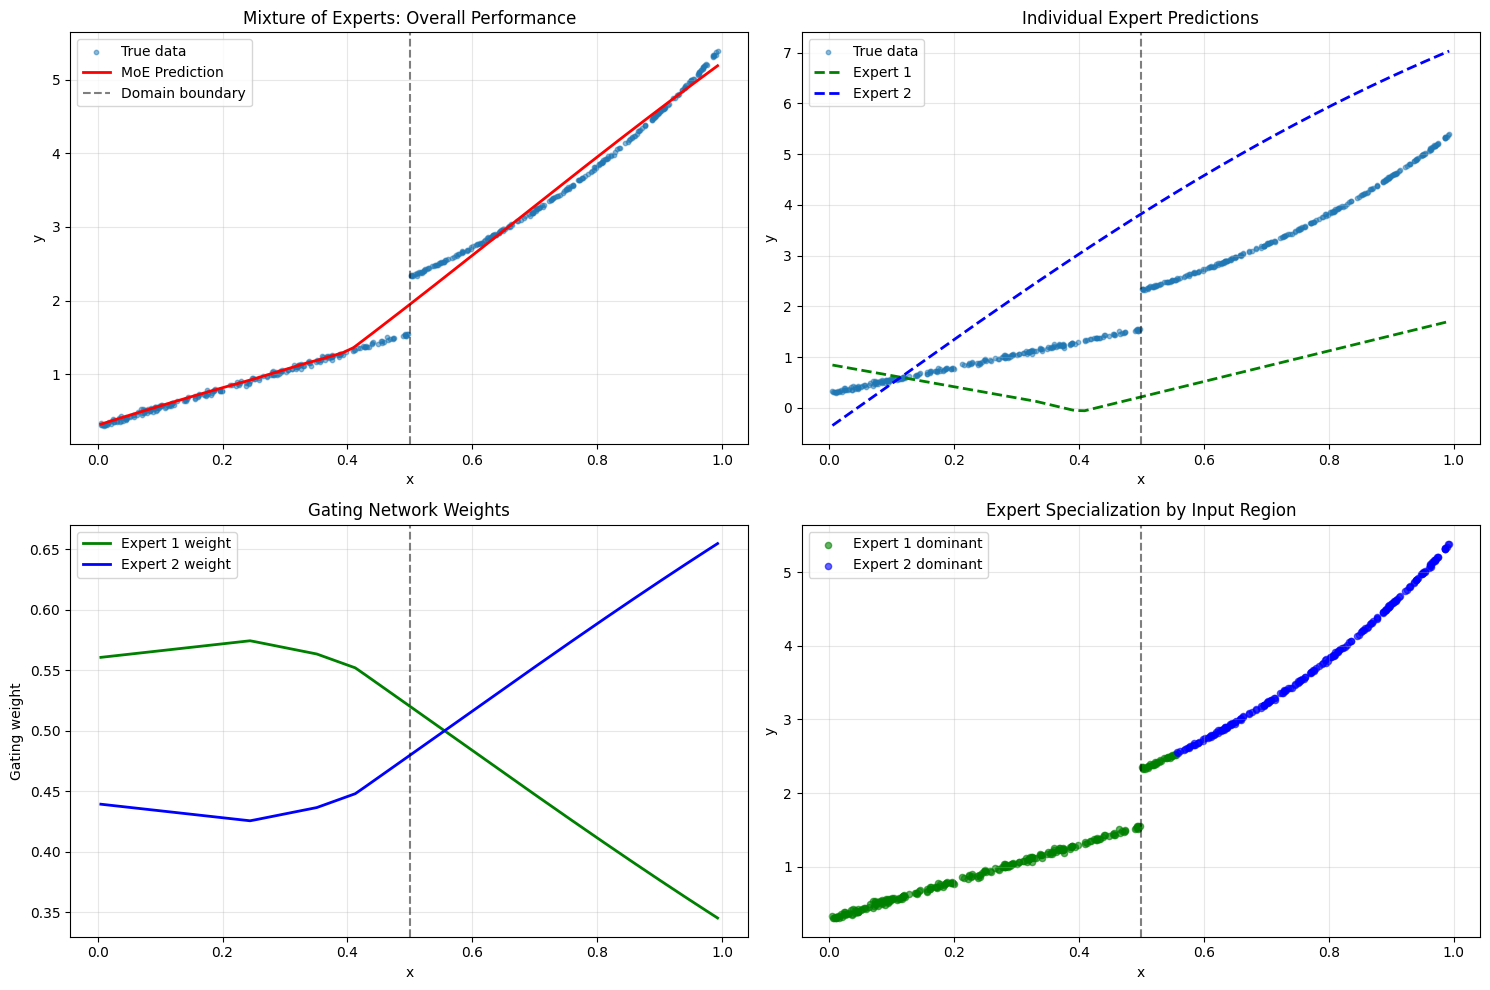


GATING EVOLUTION ANALYSIS


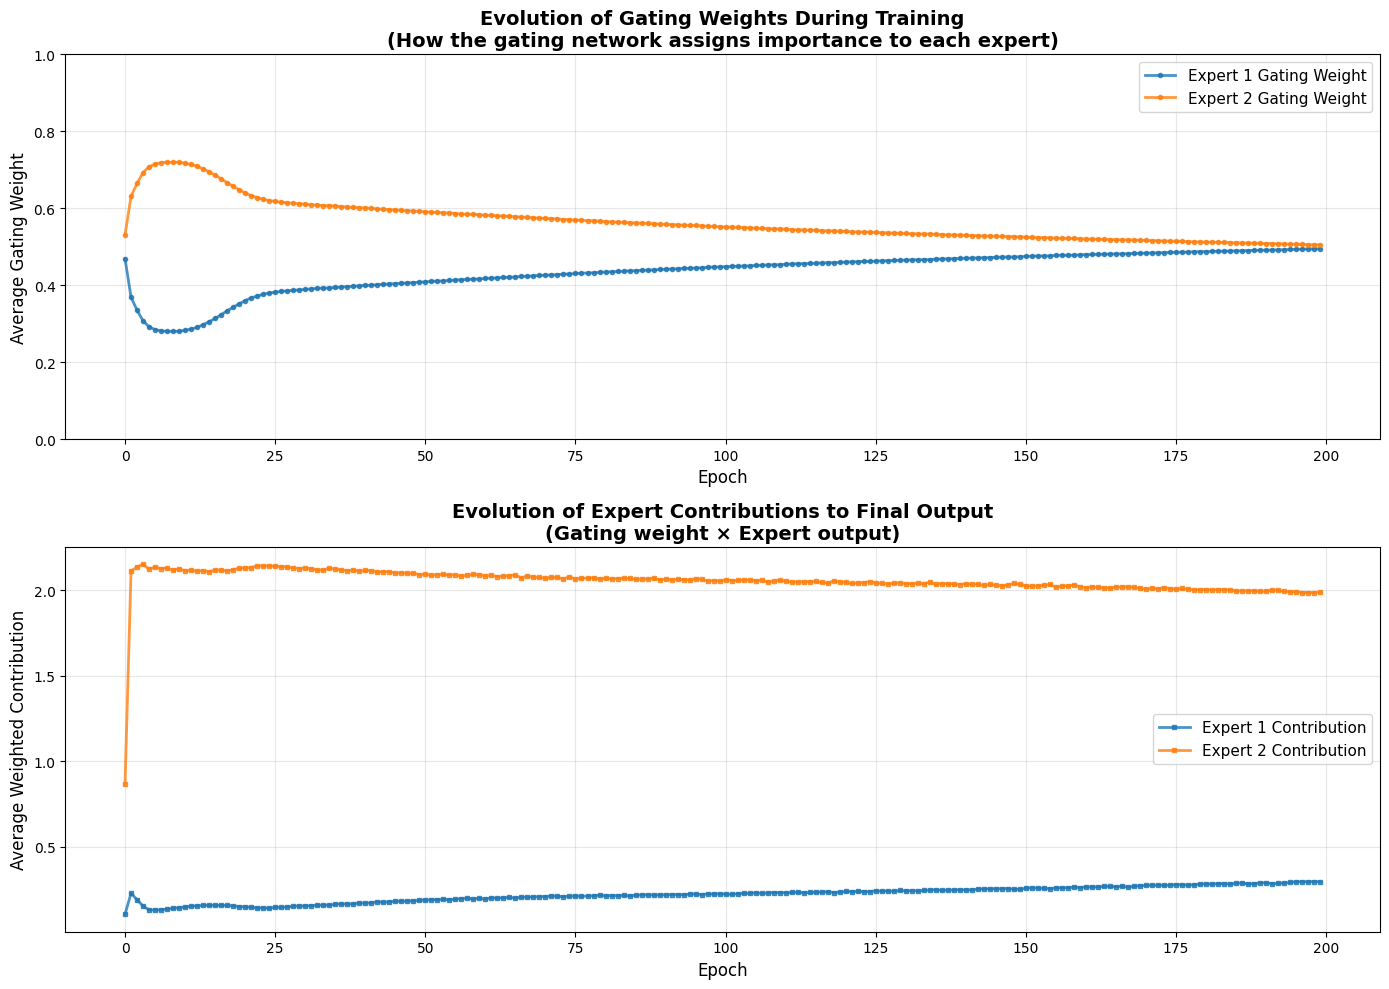


GATING EVOLUTION SUMMARY

Initial epoch (Epoch 0):
  Expert 1: Gating=0.4689, Contribution=0.1040
  Expert 2: Gating=0.5311, Contribution=0.8678

Final epoch (Epoch 199):
  Expert 1: Gating=0.4949, Contribution=0.2940
  Expert 2: Gating=0.5051, Contribution=1.9879

Change over training:
  Expert 1: Δ Gating=+0.0260, Δ Contribution=+0.1900
  Expert 2: Δ Gating=-0.0260, Δ Contribution=+1.1201

KEY INSIGHTS:
1. The gating network learns to assign higher weights to Expert 1 for some values of x,
   and Expert 2 for other ranges, matching the underlying data distribution.
2. Each expert specializes in its domain, leading to better overall performance.
3. The final prediction is a soft combination of both experts' outputs.
4. MoE principle: specialization + dynamic routing.
5. Gating evolution shows how expert responsibilities shift during training.


In [ ]:
# train
x_test, y_test, trainer = train_moe(moe_model)  

# test expert usage on selected samples
test_expert_usage(moe_model, x_test, y_test)

# summary plots
plot_results(moe_model, x_test, y_test)

# visualize gating evolution during training
print("\n" + "="*60)
print("GATING EVOLUTION ANALYSIS")
print("="*60)
plot_gating_evolution(trainer.gating_history)    

print("\n" + "="*60)
print("KEY INSIGHTS:")
print("="*60)
print("1. The gating network learns to assign higher weights to Expert 1 for some values of x,")
print("   and Expert 2 for other ranges, matching the underlying data distribution.")
print("2. Each expert specializes in its domain, leading to better overall performance.")
print("3. The final prediction is a soft combination of both experts' outputs.")
print("4. MoE principle: specialization + dynamic routing.")
print("5. Gating evolution shows how expert responsibilities shift during training.")

Found 33400 unique tokens.
Review lengths - min: 0, max: 1039, avg: 133.18


c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "moe-reviewer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gating_network (Sequential)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding (Embedding)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling1d   │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense (Dense)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_1 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expert_0 (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_1 (Embedding)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling1d_1 │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_2 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_3 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expert_1 (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_2 (Embedding)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling1d_2 │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_4 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_5 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expert_2 (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_3 (Embedding)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling1d_3 │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_6 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_7 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expert_3 (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ embedding_4 (Embedding)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling1d_4 │ ?                      │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Creating visualization for model: gating_network
Processing input layer...
Processing layer 0: Embedding
Processing layer 1: GlobalAveragePooling1D
Processing layer 2: Dense
Processing layer 3: Dense
Visualization saved as 'moe-reviewer-gating.png'


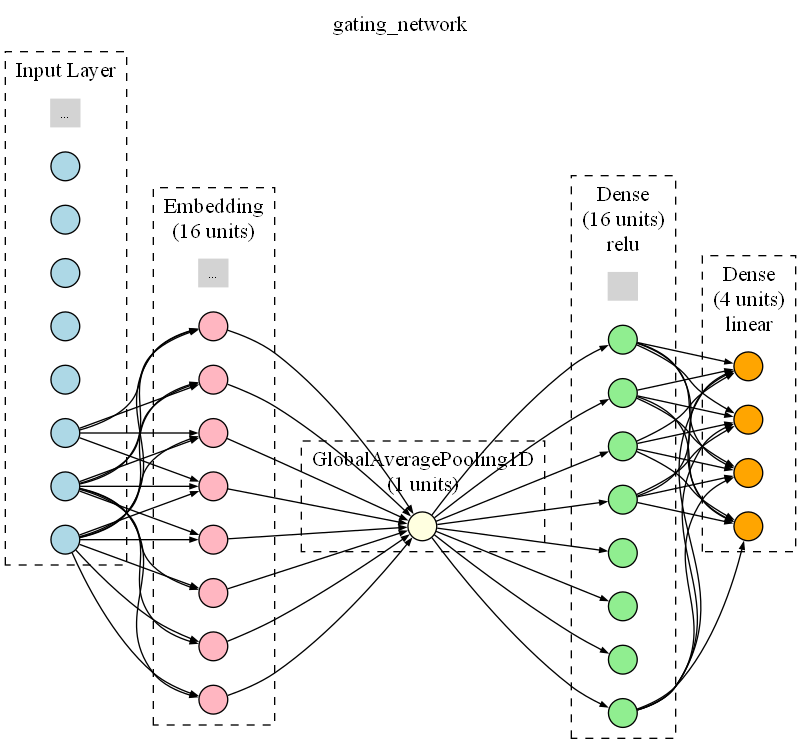

Creating visualization for model: expert_0
Processing input layer...
Processing layer 0: Embedding
Processing layer 1: GlobalAveragePooling1D
Processing layer 2: Dense
Processing layer 3: Dense
Visualization saved as 'moe-reviewer-expert-0.png'


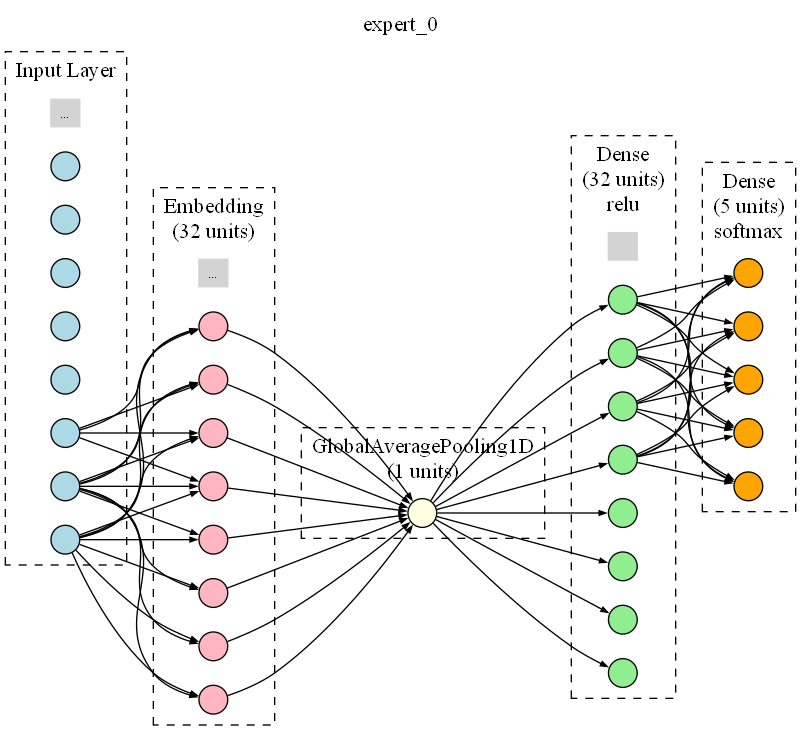

Training MoE model...


In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../02")))
from utils import display_nn_graph

# hyperparameters
vocabulary_size = 10_000
max_sequence_length = 256 # 256 tokens reasonable for reviews
num_samples = 10_000 # train and eval samples
epochs = 20
    
# Define the expert networks
def create_expert(i, input_shape, output_shape):
    model = keras.Sequential([
        layers.Embedding(input_dim=vocabulary_size, output_dim=32, input_length=input_shape), # more capable/expressive embedding for experts, to capture more complex distinctions
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_shape, activation='softmax')
    ], name=f'expert_{i}')
    return model

# Define the gating network
def create_gating_network(input_shape, num_experts):
    model = keras.Sequential([
        layers.Embedding(input_dim=vocabulary_size, output_dim=16, input_length=input_shape), #16 dim embedding, lightweight for gating, for first grained distinguish
        layers.GlobalAveragePooling1D(), 
        layers.Dense(16, activation='relu'),
        layers.Dense(num_experts, activation='linear')  
    ], name='gating_network')
    return model

# Define the MoE model
@keras.utils.register_keras_serializable()
class MixtureOfExperts(keras.Model):
    def __init__(self, num_experts=4, max_experts=2, input_shape=100, output_shape=3):
        super(MixtureOfExperts, self).__init__()
        self.name = "moe-reviewer"
        self.num_experts = num_experts
        self.max_experts = max_experts
        
        # Create the gating network
        self.gating_network = create_gating_network(input_shape, num_experts)
        
        # Create the experts
        self.experts = [create_expert(i, input_shape, output_shape) for i in range(num_experts)]
    
    def call(self, inputs, training=None, return_expert_weights=False):
        # Get the gating weights
        gating_weights = self.gating_network(inputs)
        
        # Apply softmax to get probabilities
        gating_probs = tf.nn.softmax(gating_weights, axis=1)


        # Entropy regularization:
        # data is homogeneous, the gating network may not need all experts. 
        # common issues:
        # 1. Gating network collapse to a single expert: The gating network quickly learns to route almost all inputs to a single expert (here, expert 3), especially if one expert starts performing slightly better early in training.
        # 2. Imbalanced expert training: If one expert gets most gradients, it improves faster, reinforcing the gating network’s preference.
        if training:
            if True: # auxiliary loss to encourage balanced expert usage across the batch
                mean_probs = tf.reduce_mean(gating_probs, axis=0)
                balance_loss = tf.reduce_sum((mean_probs - 1.0/self.num_experts)**2)
                self.add_loss(0.02 * balance_loss)

        
        # Select the top k experts
        top_k_values, top_k_indices = tf.math.top_k(gating_probs, k=self.max_experts)
        
        # Create proper indices for tensor_scatter_nd_update
        # Need to include batch indices: [batch_idx, expert_idx]
        batch_size = tf.shape(inputs)[0]
        batch_indices = tf.reshape(tf.range(batch_size), [-1, 1])  # [batch_size, 1]
        batch_indices = tf.tile(batch_indices, [1, self.max_experts])  # [batch_size, max_experts]
        
        # Stack to create proper indices shape: [batch_size, max_experts, 2]
        scatter_indices = tf.stack([batch_indices, top_k_indices], axis=-1)
        
        # Create a mask for the selected experts
        mask = tf.zeros_like(gating_probs)
        mask = tf.tensor_scatter_nd_update(mask, scatter_indices, top_k_values)
        
        # Normalize the mask to get the final weights
        expert_weights = mask * gating_probs
        expert_weights = expert_weights / tf.reduce_sum(expert_weights, axis=1, keepdims=True)
        
        # Get the outputs from all experts
        expert_outputs = [expert(inputs) for expert in self.experts]
        
        # Combine the expert outputs
        combined_output = tf.zeros_like(expert_outputs[0])
        for i in range(self.num_experts):
            weight = tf.expand_dims(expert_weights[:, i], axis=1)
            combined_output += weight * expert_outputs[i]
        
        # Return only prediction during training, or both if explicitly requested
        if return_expert_weights:
            return combined_output, expert_weights
        return combined_output


dataset = load_dataset("yelp_review_full")
train_dataset=dataset["train"].shuffle(seed=42).select(range(num_samples)), 
eval_dataset=dataset["test"].shuffle(seed=42).select(range(num_samples)),
train_texts = train_dataset[0]['text']
train_labels = train_dataset[0]['label']

# Tokenize the texts
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(train_texts) # Fit tokenizer on training texts
word_index = tokenizer.word_index
# more tokenizer info
print(f"Found {len(word_index)} unique tokens.")
sequences = tokenizer.texts_to_sequences(train_texts) # Convert texts to sequences of integers
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length) # Pad sequences to max length, for example 100
# get min,max,avg tokens per review
lengths = [len(seq) for seq in sequences]
print(f"Review lengths - min: {min(lengths)}, max: {max(lengths)}, avg: {sum(lengths)/len(lengths):.2f}")

# Convert labels to one-hot encoding
one_hot_labels = keras.utils.to_categorical(train_labels, num_classes=5)

# Create the MoE model
input_shape = max_sequence_length  # Max sequence length
output_shape = 5   # Number of classes to classify
moe_model = MixtureOfExperts(num_experts=4, max_experts=2, input_shape=input_shape, output_shape=output_shape)

# Compile the model
moe_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
moe_model.summary(expand_nested=True)
gating_model = moe_model.gating_network
display_nn_graph(gating_model,"moe-reviewer-gating")
expert_model = moe_model.get_layer("expert_0")
display_nn_graph(expert_model,"moe-reviewer-expert-0")

# Train the model
print("Training MoE model...")
history = moe_model.fit(padded_sequences, one_hot_labels, epochs=epochs, batch_size=64, verbose=1)
moe_model.save("moe-reviewer-model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step

Test text: 'A delightful experience with a cozy atmosphere and great music.'
Model output: [[0.05245468 0.32534152 0.24825098 0.05900792 0.3149449 ]]
Predicted class: 1 (1)

Expert weights: [0.63325053 0.         0.36674947 0.        ]
Selected experts: [0 2]

Individual Expert Outputs:
Expert 0 output: [8.2804866e-02 5.1373863e-01 3.8623232e-01 1.6765717e-02 4.5850326e-04]
  Predicted class: 1
  ✓ Selected with weight 0.6333
Expert 1 output: [0.02050739 0.91343004 0.00241495 0.0497954  0.01385217]
  Predicted class: 1
  ✗ Not selected (weight: 0.0000)
Expert 2 output: [5.0313152e-05 4.4369786e-05 1.0004520e-02 1.3194573e-01 8.5795504e-01]
  Predicted class: 4
  ✓ Selected with weight 0.3667
Expert 3 output: [5.3457152e-03 5.9385377e-01 4.8373155e-03 3.9559636e-01 3.6687785e-04]
  Predicted class: 1
  ✗ Not selected (weight: 0.0000)
                                                 text  pred                                                        

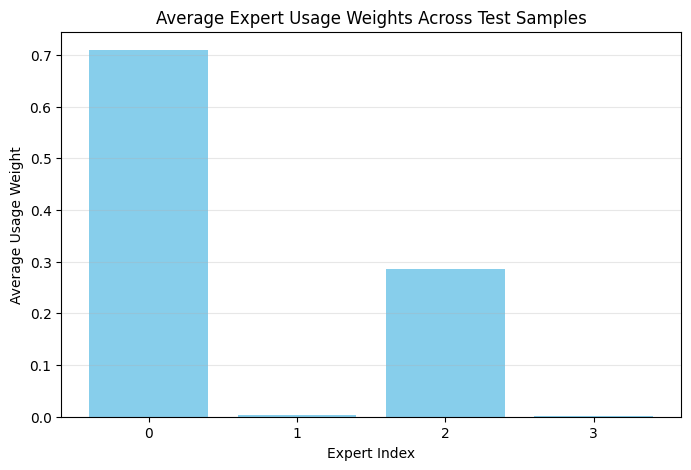

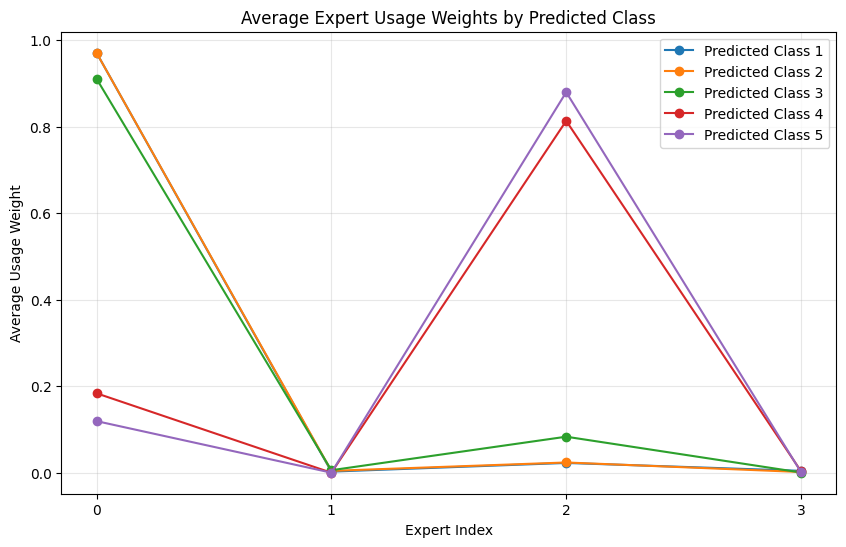

In [5]:
import pandas as pd
# Test the model with a sample input
test_text = "A delightful experience with a cozy atmosphere and great music."
test_sequence = tokenizer.texts_to_sequences([test_text])
test_padded = pad_sequences(test_sequence, maxlen=max_sequence_length)

# Get the model output (prediction only)
output = moe_model.predict(test_padded)
print(f"\nTest text: '{test_text}'")
print(f"Model output: {output}")
print(f"Predicted class: {np.argmax(output, axis=1)[0]} ({[0, 1, 2, 3, 4][np.argmax(output, axis=1)[0]]})")

# Get expert weights separately for analysis
output_with_weights, expert_weights = moe_model(test_padded, return_expert_weights=True)
print(f"\nExpert weights: {expert_weights[0].numpy()}")

# Get the indices of the top 2 experts
top_experts = np.argsort(expert_weights[0].numpy())[-2:][::-1]
print(f"Selected experts: {top_experts}")

# Show the output of each expert
print("\nIndividual Expert Outputs:")
for i, expert in enumerate(moe_model.experts):
    expert_output = expert.predict(test_padded, verbose=0)
    predicted_class = np.argmax(expert_output, axis=1)[0]
    print(f"Expert {i} output: {expert_output[0]}")
    print(f"  Predicted class: {predicted_class}") 
    if i in top_experts:
        print(f"  ✓ Selected with weight {expert_weights[0][i]:.4f}")
    else:
        print(f"  ✗ Not selected (weight: {expert_weights[0][i]:.4f})")

#moe_model = keras.models.load_model("moe-model.keras", compile=False)
#moe = MixtureOfExperts(moe_model)
#moe.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#moe.summary()
dataset = load_dataset("yelp_review_full")
num_samples = 100
eval_dataset=dataset["test"].shuffle(seed=42).select(range(num_samples)),
texts = eval_dataset[0]['text']
labels = eval_dataset[0]['label']
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

results = []
for i in range(len(texts)):
    prediction = moe_model.predict(padded_sequences[i:i+1], verbose=0)
    output_with_weights, expert_weights = moe_model(padded_sequences[i:i+1], return_expert_weights=True)
    predicted_class = np.argmax(prediction, axis=1)[0] + 1  # Adjusting for 1-5 star scale
    text = texts[i][:50] + ("..." if len(texts[i]) > 50 else "")
    results.append({
        "text": text,
        "pred": predicted_class,
        "prob": output_with_weights[0].numpy(),
        "expert_weights": expert_weights[0].numpy(),
        "top_experts": np.argsort(expert_weights[0].numpy())[-2:][::-1],
        "actual": labels[i],
        "result": "✅" if predicted_class == labels[i] else ("🟡" if abs(predicted_class - labels[i]) == 1 else "❌")
    })
results_df = pd.DataFrame(results)
print(results_df[:20].to_string(index=False))

# visualize expert usage
import matplotlib.pyplot as plt
expert_usage = np.array([res['expert_weights'] for res in results])
avg_usage = np.mean(expert_usage, axis=0)
plt.figure(figsize=(8, 5))
plt.bar(range(len(avg_usage)), avg_usage, color='skyblue')
plt.xlabel('Expert Index')
plt.ylabel('Average Usage Weight')
plt.title('Average Expert Usage Weights Across Test Samples')
plt.xticks(range(len(avg_usage)))
plt.grid(axis='y', alpha=0.3)
plt.show()
#expert usage per predicted class
usage_by_class = {i: [] for i in range(1, 6)}
for res in results:
    usage_by_class[res['pred']].append(res['expert_weights'])
avg_usage_by_class = {k: np.mean(v, axis=0) for k, v in usage_by_class.items() if v}
plt.figure(figsize=(10, 6))
for cls, usage in avg_usage_by_class.items():
    plt.plot(range(len(usage)), usage, marker='o', label=f'Predicted Class {cls}')
plt.xlabel('Expert Index')
plt.ylabel('Average Usage Weight')
plt.title('Average Expert Usage Weights by Predicted Class')
plt.xticks(range(len(avg_usage)))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- [OpenAI gpt-oss Moe](https://arxiv.org/html/2508.10925v1#S2)

In [1]:
import os
print(os.environ["HF_HOME"])

D:\.cache\huggingface


In [ ]:
!uv pip install flash_attn

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import torch

model_base="AIChenKai/TinyLlama-1.1B-Chat-v1.0-x2-MoE"
model_name = model_base
#model_base = "Qwen/Qwen3-0.6B"
#model_base = "google/gemma-3-1b-it"
#model_name = os.path.join(os.environ['HF_HOME'], 'hub', f'models--{model_base.replace("/", "--")}-q8')
#model_name = os.path.join(os.environ['HF_HOME'], 'hub', f'models--{model_base.replace("/", "--")}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)
try:
    model.to(device) # .to` is not supported for `8-bit` bitsandbytes models. Please use the model as it is, since the model has already been set to the correct devices and casted to the correct `dtype`
except:
    pass

print(f"Model config: {model.config}")
print(f"\nModel structure:")
print(f"Number of parameters: {model.num_parameters():,}")
print(f"Number of layers: {model.config.num_hidden_layers}")

def inspect_moe_architecture(model):
    """Inspect the MoE structure in the model."""
    
    # Find MoE layers
    moe_layers = []
    for name, module in model.named_modules():
        if 'block_sparse_moe' in name.lower() or 'moe' in name.lower():
            moe_layers.append((name, module))
    
    print(f"Found {len(moe_layers)} MoE modules")
    
    if moe_layers:
        print("\nFirst MoE layer structure:")
        name, layer = moe_layers[0]
        print(f"Name: {name}")
        print(f"Type: {type(layer)}")
        
        # Try to get number of experts
        if hasattr(layer, 'num_experts'):
            print(f"Number of experts: {layer.num_experts}")
        if hasattr(layer, 'top_k'):
            print(f"Top-K: {layer.top_k}")
        
        print(f"\nLayer attributes: {dir(layer)[:10]}...")
    
    # Check model config
    if hasattr(model.config, 'num_local_experts'):
        print(f"\nFrom config:")
        print(f"Number of experts: {model.config.num_local_experts}")
        print(f"Top-K: {model.config.num_experts_per_tok}")
    
    return moe_layers

moe_layers = inspect_moe_architecture(model)

class ExpertTracker:
    """Track expert activations during model inference."""
    
    def __init__(self):
        self.expert_activations = []
        self.routing_weights = []
        self.hooks = []
    
    def register_hooks(self, model):
        """Register forward hooks to capture expert routing."""
        
        def hook_fn(module, input, output):
            # Mixtral's MoE layers expose router_logits in output
            if isinstance(output, tuple) and len(output) > 1:
                # Try to extract routing information
                if hasattr(output, 'router_logits'):
                    router_logits = output.router_logits
                elif len(output) > 2:
                    router_logits = output[2]  # Usually the third element
                else:
                    return
                
                if router_logits is not None:
                    # Get top-k experts
                    routing_weights = torch.nn.functional.softmax(router_logits, dim=-1)
                    top_k_weights, top_k_indices = torch.topk(routing_weights, k=2, dim=-1)
                    
                    self.routing_weights.append(routing_weights.detach().cpu())
                    self.expert_activations.append({
                        'indices': top_k_indices.detach().cpu(),
                        'weights': top_k_weights.detach().cpu()
                    })
        
        # Register hooks on MoE layers
        for name, module in model.named_modules():
            if 'block_sparse_moe' in name.lower() or 'moe' in name.lower():
                handle = module.register_forward_hook(hook_fn)
                self.hooks.append(handle)
        
        print(f"Registered {len(self.hooks)} hooks on MoE layers")
    
    def clear(self):
        """Clear stored activations."""
        self.expert_activations = []
        self.routing_weights = []
    
    def remove_hooks(self):
        """Remove all hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

# Create tracker
tracker = ExpertTracker()
tracker.register_hooks(model)

def generate_and_track(prompt, max_new_tokens=50):
    """Generate text and track expert activations."""
    tracker.clear()
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Generate
    with torch.no_grad():
        try:
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                #temperature=0.7,
                #top_p=0.9,
                output_router_logits=True,  # Enable router logit output
                return_dict_in_generate=True
            )
        except Exception as e:
            print(f"⚠ Warning: output_router_logits not supported. Error: {e}")
            print("Falling back to standard generation...")
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,

                return_dict_in_generate=True
            )
    
    # Decode output
    if hasattr(outputs, 'sequences'):
        generated_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    else:
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return generated_text, tracker.expert_activations

# Test prompts covering different domains
test_prompts = [
    "Write a Python function to calculate fibonacci numbers:",
    "Explain the theory of relativity in simple terms:",
    "What are the best practices for cooking pasta?",
    "Describe the water cycle in nature:"
]

print("Testing text generation with expert tracking...")
print("Note: This model may not expose router logits during generation.")
print("="*80)

results = {}
for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    print("-"*80)
    
    try:
        text, activations = generate_and_track(prompt, max_new_tokens=30)
        print(f"Generated: {text}")
        print(f"Captured {len(activations)} MoE layer activations")
        results[prompt[:30] + "..."] = activations
    except Exception as e:
        print(f"❌ Error during generation: {e}")
        print(f"Skipping this prompt...")
        results[prompt[:30] + "..."] = []

print("\n" + "="*80)
if not any(results.values()):
    print("⚠ No expert activations captured.")
    print("This can happen because:")
    print("1. The model doesn't expose router logits during generation")
    print("2. The model architecture doesn't match expected MoE structure")
    print("3. Router logits are only available during forward pass, not generation")
    print("\nTry using a forward pass instead of generation to capture activations.")
else:
    print(f"✓ Successfully captured activations from {sum(1 for v in results.values() if v)} prompts")

# Alternative approach: Use forward pass to capture expert activations
def analyze_prompt_with_forward(prompt):
    """Analyze expert usage during forward pass (not generation)."""
    tracker.clear()
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs, output_router_logits=True)
    
    return tracker.expert_activations

print("\n" + "="*80)
print("Alternative: Analyzing expert usage during FORWARD PASS")
print("="*80)

forward_results = {}
for prompt in test_prompts:
    print(f"\nPrompt: {prompt[:50]}...")
    try:
        activations = analyze_prompt_with_forward(prompt)
        print(f"✓ Captured {len(activations)} MoE layer activations")
        forward_results[prompt[:30] + "..."] = activations
    except Exception as e:
        print(f"❌ Error: {e}")
        forward_results[prompt[:30] + "..."] = []

# Use forward_results if generation results are empty
if not any(results.values()) and any(forward_results.values()):
    print("\n✓ Using forward pass results instead of generation results")
    results = forward_results    

import numpy as np
import matplotlib.pyplot as plt
def visualize_expert_usage_by_prompt(results, num_experts=6):
    """Visualize which experts are used for different prompts."""
    
    fig, axes = plt.subplots(len(results), 1, figsize=(14, 4 * len(results)))
    if len(results) == 1:
        axes = [axes]
    
    for idx, (prompt, activations) in enumerate(results.items()):
        if not activations:
            axes[idx].text(0.5, 0.5, 'No activation data captured', 
                         ha='center', va='center')
            axes[idx].set_title(f"Prompt: {prompt}")
            continue
        
        # Aggregate expert usage across all layers
        expert_counts = np.zeros(num_experts)
        
        for layer_activation in activations:
            if 'indices' in layer_activation:
                indices = layer_activation['indices'].numpy().flatten()
                for expert_idx in indices:
                    if expert_idx < num_experts:
                        expert_counts[expert_idx] += 1
        
        # Plot
        axes[idx].bar(range(num_experts), expert_counts, color='steelblue', alpha=0.7)
        axes[idx].set_xlabel('Expert ID')
        axes[idx].set_ylabel('Activation Count')
        axes[idx].set_title(f"Expert Usage - Prompt: {prompt}")
        axes[idx].set_xticks(range(num_experts))
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize results
if results and any(results.values()):
    visualize_expert_usage_by_prompt(results)
else:
    print("No activation data captured. The model might not expose router logits.")
    print("This is common with quantized or optimized models.")    

import seaborn as sns
import pandas as pd
def create_expert_specialization_heatmap(results, num_experts=6):
    """Create a heatmap showing expert specialization across prompts."""
    
    # Create matrix: prompts x experts
    matrix = np.zeros((len(results), num_experts))
    prompt_labels = []
    
    for prompt_idx, (prompt, activations) in enumerate(results.items()):
        prompt_labels.append(prompt[:40] + "..." if len(prompt) > 40 else prompt)
        
        if not activations:
            continue
        
        for layer_activation in activations:
            if 'indices' in layer_activation:
                indices = layer_activation['indices'].numpy().flatten()
                for expert_idx in indices:
                    if expert_idx < num_experts:
                        matrix[prompt_idx, expert_idx] += 1
    
    # Normalize by row (per prompt)
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix_normalized = np.divide(matrix, row_sums, where=row_sums!=0)
    
    # Plot
    plt.figure(figsize=(12, max(6, len(results) * 0.8)))
    sns.heatmap(matrix_normalized, 
                annot=True, fmt='.2f', 
                cmap='YlOrRd',
                xticklabels=[f'Expert {i}' for i in range(num_experts)],
                yticklabels=prompt_labels,
                cbar_kws={'label': 'Usage Proportion'})
    plt.title('Expert Specialization by Input Type\n(Proportion of activations per expert)')
    plt.xlabel('Expert ID')
    plt.ylabel('Prompt Type')
    plt.tight_layout()
    plt.show()
    
    return matrix, matrix_normalized

if results and any(results.values()):
    usage_matrix, normalized_matrix = create_expert_specialization_heatmap(results)
    print("\nRaw expert usage counts:")
    print(pd.DataFrame(usage_matrix, 
                      columns=[f'Expert {i}' for i in range(usage_matrix.shape[1])],
                      index=[p[:30] for p in results.keys()]))    

# Remove hooks
tracker.remove_hooks()

# Clear memory
del model
del tokenizer

print("Cleanup complete!")                      

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Model config: MixtralConfig {
  "architectures": [
    "MixtralForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float32",
  "eos_token_id": 2,
  "head_dim": null,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "model_type": "mixtral",
  "num_attention_heads": 32,
  "num_experts_per_tok": 2,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "num_local_experts": 2,
  "output_router_logits": false,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "router_aux_loss_coef": 0.001,
  "router_jitter_noise": 0.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "transformers_version": "4.56.2",
  "use_cache": true,
  "vocab_size": 32000
}


Model structure:
Number of parameters: 1,861,404,672
Number of layers: 22
Found 286 MoE modules

First MoE layer structure:
Name: model.layer

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


⚠ Warning: output_router_logits not supported. Error: The size of tensor a (22) must match the size of tensor b (13) at non-singleton dimension 0
Falling back to standard generation...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated: Write a Python function to calculate fibonacci numbers: for more than 3 digits, use a list or a dictionary to maintain a history of previous results, to avoid repetition.
Captured 0 MoE layer activations

Prompt: Explain the theory of relativity in simple terms:
--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


⚠ Warning: output_router_logits not supported. Error: The size of tensor a (22) must match the size of tensor b (13) at non-singleton dimension 0
Falling back to standard generation...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated: Explain the theory of relativity in simple terms: The theory of relativity is a mathematical description of the physical world according to which all phenomena in the universe, including the behavior of matter and energy
Captured 0 MoE layer activations

Prompt: What are the best practices for cooking pasta?
--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated: What are the best practices for cooking pasta?
Captured 0 MoE layer activations

Prompt: Describe the water cycle in nature:
--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


⚠ Warning: output_router_logits not supported. Error: The size of tensor a (22) must match the size of tensor b (20) at non-singleton dimension 0
Falling back to standard generation...
Generated: Describe the water cycle in nature:
Captured 0 MoE layer activations

⚠ No expert activations captured.
This can happen because:
1. The model doesn't expose router logits during generation
2. The model architecture doesn't match expected MoE structure
3. Router logits are only available during forward pass, not generation

Try using a forward pass instead of generation to capture activations.

Alternative: Analyzing expert usage during FORWARD PASS

Prompt: Write a Python function to calculate fibonacci num...
✓ Captured 0 MoE layer activations

Prompt: Explain the theory of relativity in simple terms:...
✓ Captured 0 MoE layer activations

Prompt: What are the best practices for cooking pasta?...
✓ Captured 0 MoE layer activations

Prompt: Describe the water cycle in nature:...
✓ Captured 0 M